In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import mne 
from sklearn.decomposition import PCA
from cedalion.sigdecomp import ERBM as ERBM
import scipy as sp  

# Extracting Cardiac Sources from fNIRS Data Using ICA ERBM 

In [2]:
# load fNIRS data 
data = mne.io.read_raw_snirf("resting_state_example.snirf")

# get the sampling rate 
sampling_rate = data.info['sfreq'] 
print('Sampling Rate: ', sampling_rate)


# crop data before experiment starts  
start_event = data.annotations.onset[0]  

# resting state data was collected for 300 seconds  
recording_time = 300    
data.crop(tmin=start_event, tmax = start_event + recording_time) 


Loading /Users/jackybehrendt/Desktop/IBS/ERBM/resp_data/example/resting_state_example.snirf
Sampling Rate:  4.8828125


<RawSNIRF | resting_state_example.snirf, 200 x 1466 (300.0 s), ~309 kB, data not loaded>

In [3]:
# convert raw data to optical density 
data = mne.preprocessing.nirs.optical_density(data).get_data()


Reading 0 ... 1465  =      0.000 ...   300.032 secs...


In [4]:
def apply_pca(data, var = 0.99):  
    # this function applies PCA to fNIRS data to reduce the number of channels 
    # and returns the reduced data  
      
    X = data.T
    print('Original Data shape : ',X.T.shape) 
    pca = PCA().fit(X)   

    # choose number of components to keep 
    N = np.where(np.cumsum(pca.explained_variance_ratio_) > var)[0][1]    
    pca = PCA(n_components=N)  
    X_reduced = pca.fit_transform(X).T    

    # new shape of data 
    print('Reduced Data shape : ',X_reduced.shape)

    # compute variance explained through first N principle components
    explained_var = pca.explained_variance_ratio_
    print('Explained Variance = ',np.round(np.sum(explained_var), 4 ))
    return X_reduced   

In [5]:
# apply PCA to data, keep 99% of variance   
X_reduced = apply_pca(data, 0.99)

Original Data shape :  (200, 1466)


Reduced Data shape :  (32, 1466)
Explained Variance =  0.9903


In [6]:
# apply ERBM to data to obtain demixing matrix W 

# this computation may take a minute 
W = ERBM.ERBM(X_reduced)

# compute separated source as S = W * X 
car_sources = W.dot(X_reduced)

In [7]:
def contrast_sources(sources, bands,  l = 5): 
    # this function computes the contrast between the cardiac band and the complementary band
    # it returns the indices of l sources with the highest contrast

    # power spectrum density of sources
    psd_sources = np.abs(np.fft.fft(sources, axis = 1))**2

    # the frequencies corresponding to the power spectrum 
    freqs = np.fft.fftfreq(sources.shape[1], 1/sampling_rate)

    # choose frequencies in the band 
    cardiac_band_ind = np.logical_and(freqs >= bands[1], freqs <= bands[2]) 

    # use bands to compute contrast
    comp_band =  np.logical_and(freqs >= bands[0], freqs < bands[1]) +  np.logical_and(freqs > bands[2] , freqs <= bands[3]) 

    # compute contrast between psd bands 
    psd_quotient = np.sum(psd_sources[:, cardiac_band_ind], axis = 1 ) / np.sum(psd_sources[:, comp_band], axis = 1 )

    # choose index of  sources with maximal contrast 
    max_contrast_index = np.argsort(psd_quotient, axis = 0 )[-l:]

    # reverse the order of the sources  
    max_contrast_index = max_contrast_index[::-1]   


    return max_contrast_index

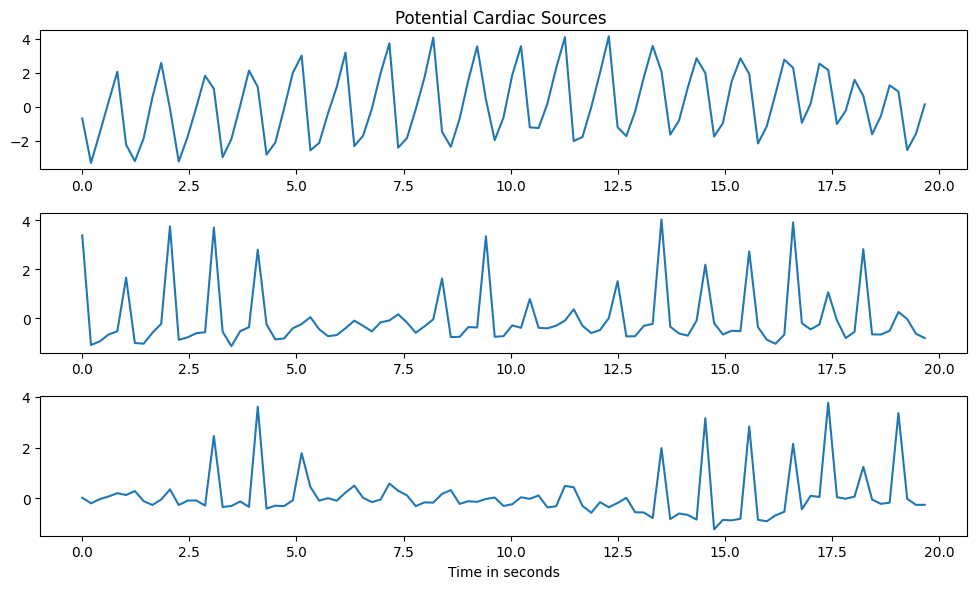

In [8]:
# set the bands where the cardiac signal is expected (in Hz)
bands = [ 0.0, 0.5, 1.5 , 3.0 ] 

# compute the indices of sources with maximal contrast  
l = 3 
max_contrast_index = contrast_sources(car_sources, bands, l )
                               
# set how many seconds are plotted 
seconds = 20 

# multiply number of seconds with sampling rate 
source_len = int(sampling_rate * seconds ) 

# plot source with highest contrast 
fig, ax = plt.subplots(l, 1,  figsize = (10, l* 2 )) 

# set title 
ax[0].set_title('Potential Cardiac Sources ', fontsize=12 , y = 0.99)

# label x-axis 
ax[-1].set_xlabel('Time in seconds')

# plot source 
for i in range(l):        
    ax[i].plot((1/sampling_rate) * np.arange(0, source_len), car_sources[max_contrast_index[i], :source_len])

plt.tight_layout()  

plt.show()

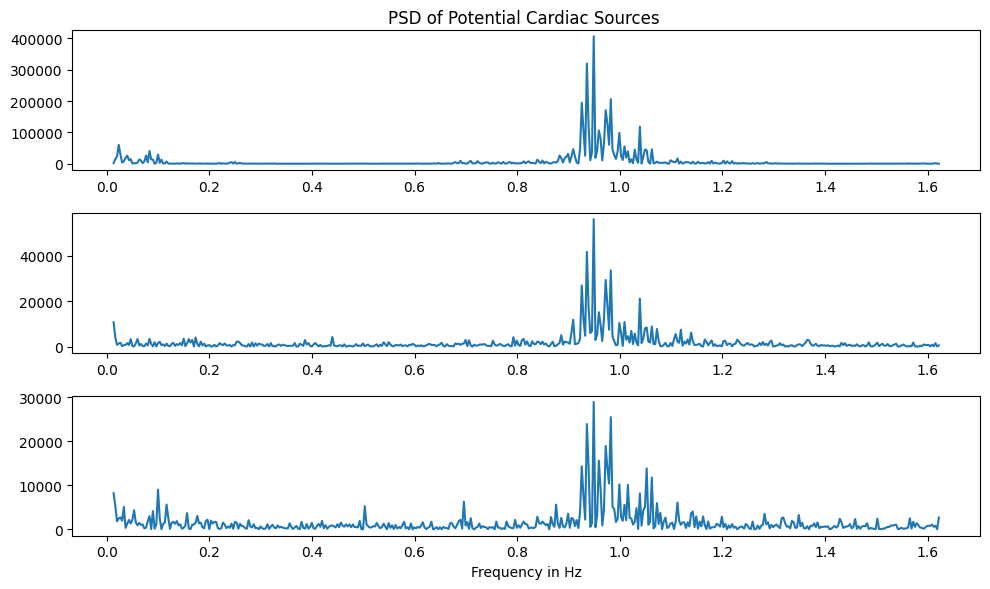

In [9]:
# plot power spectrum density of sources with highest contrast  
fig, ax = plt.subplots(l, 1, figsize = (10, l * 2 )) 
 
# the frequencies corresponding to the power spectrum
freqs = np.fft.fftfreq(car_sources.shape[1], 1/sampling_rate)   
freq_len = int(np.floor(freqs.shape[0]/3))

# start of frequency band  
min_freq = 0.01 
freq_start = np.argwhere(freqs > min_freq)[0,0]

# compute power spectrum density of sources 
psd_sources = np.abs(np.fft.fft(car_sources, axis = 1))**2  

# set title 
ax[0].set_title('PSD of Potential Cardiac Sources ', fontsize=12 , y = 0.99)

# label x-axis  
ax[-1].set_xlabel('Frequency in Hz')

# plot psd of sources   
for i in range(l):  
    ax[i].plot( freqs[freq_start:freq_len],  psd_sources[ max_contrast_index[i] ,freq_start :freq_len]) 

plt.tight_layout()  
plt.show()

# Extracting Respiratory Signals from fNIRS Data 

In [10]:
# bandpass filter data 
data = mne.filter.filter_data(data, sampling_rate,l_freq = 0.1, h_freq= 0.5, method='iir', verbose = False) 

In [11]:
# apply PCA to reduce the number of channels, keep 99% of variance
X_reduced = apply_pca(data, 0.99)

# apply ERBM to data to obtain demixing matrix W 
W_resp = ERBM.ERBM(X_reduced)

# compute separated source as S = W * X 
resp_sources = W_resp.dot(X_reduced)

Original Data shape :  (200, 1466)
Reduced Data shape :  (44, 1466)
Explained Variance =  0.9901


In [12]:
# load simultaneously recorded respiratory data     
file_name = 'resp_signal.vhdr'

# load respiratory data    
resp_data = mne.io.read_raw_brainvision(file_name, preload=True)        

# crop data 
resp_data.crop(tmin=resp_data.annotations.onset[1],  tmax=resp_data.annotations.onset[1] + recording_time)  

# downsample respiratory data to match fNIRS data 
resp_data.resample(sampling_rate)

# get respiratory data
resp_data = resp_data.get_data('Resp')

Extracting parameters from resp_signal.vhdr...


Setting channel info structure...
Reading 0 ... 190519  =      0.000 ...   381.038 secs...


/var/folders/_r/p9nfbt5x6qq0d9bb35tnkmbm0000gn/T/ipykernel_36646/544408302.py:5: RuntimeWarning: No coordinate information found for channels ['Resp']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  resp_data = mne.io.read_raw_brainvision(file_name, preload=True)
/var/folders/_r/p9nfbt5x6qq0d9bb35tnkmbm0000gn/T/ipykernel_36646/544408302.py:5: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  resp_data = mne.io.read_raw_brainvision(file_name, preload=True)
/var/folders/_r/p9nfbt5x6qq0d9bb35tnkmbm0000gn/T/ipykernel_36646/544408302.py:5: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (250.00 Hz, Nyquist limit) will be stored.
  resp_data = mne.io.read_raw_brainvision(file_name, preload=True)
/var/folders/_r/p9nfbt5x6qq0d9bb35tnkmbm0000gn/T/ipykernel_36646/544408302.py:5: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['

# Compute Correlation between ICA ERBM Sources and Respiratory Signal 

In [13]:
# apply z transformation to sources and respiratory data    
resp_sources_zt = sp.stats.zscore(resp_sources, axis = 1) 
resp_zt = sp.stats.zscore(resp_data, axis = 1).flatten()     

# time shift between sources and respiratory data
time_shift = int(sampling_rate * 2) 

correlations = np.zeros((resp_sources_zt.shape[0],time_shift ))

for i in range(resp_sources_zt.shape[0]): 
    for j in range(time_shift): 
        series1  = resp_sources_zt[i, j: -1]  
        series2 = resp_zt[: series1.shape[0]]          
        correlations[i,j] = np.corrcoef(series1, series2)[0,1] 


# for each time shift, choose the source with maximal correlation   
index = np.argmax(np.abs(correlations), axis = 0)   

# remove duplicates 
index = np.unique(index)   


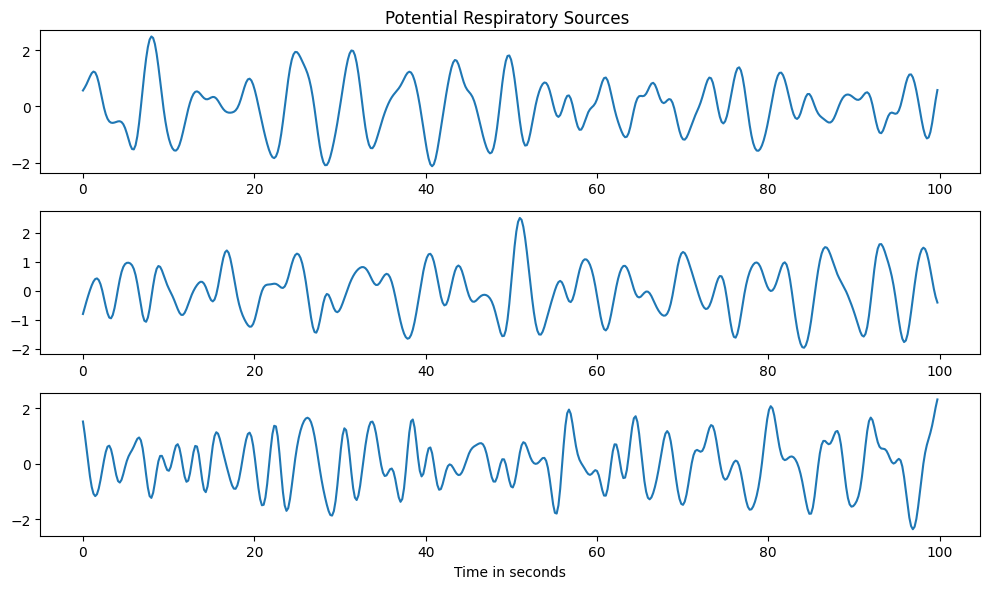

In [14]:
# set how many seconds are plotted 
seconds = 100

# multiply number of seconds with sampling rate 
source_len = int(sampling_rate * seconds ) 


fig, ax = plt.subplots(len(index), 1,  figsize = (10, len(index) * 2 )) 

# set title 
ax[0].set_title('Potential Respiratory Sources ', fontsize=12 , y = 0.99)

# label x-axis 
ax[-1].set_xlabel('Time in seconds')

# choose start time 
start_seconds = 30 
start = int(sampling_rate * start_seconds)  

# plot source with highest correlation 
for j in range(len(index)):       
    ax[j].plot((1/sampling_rate) * np.arange(0, source_len), resp_sources_zt[index[j], start : start + source_len])

      
plt.tight_layout()  
plt.show()

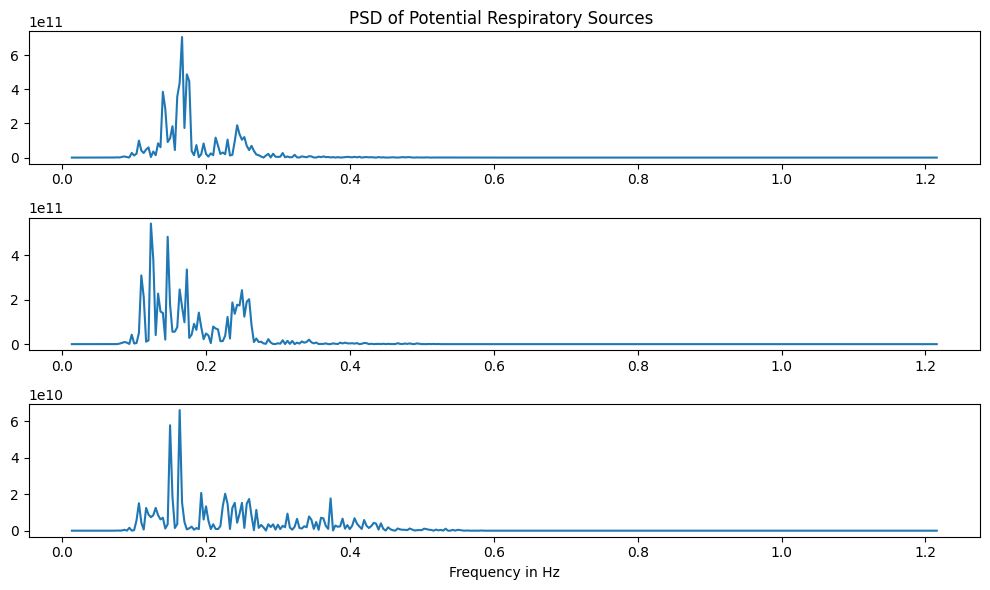

In [15]:
fig, ax = plt.subplots(len(index), 1, figsize = (10, len(index) * 2 )) 

# plot power spectrum density of sources with highest correlation to respiratory signal 
freqs = np.fft.fftfreq(resp_sources.shape[1], 1/sampling_rate)   
freq_len = int(np.floor(freqs.shape[0]/4))

# start of frequency band  
min_freq = 0.01 
freq_start = np.argwhere(freqs > min_freq)[0,0]

# compute power spectrum density of sources 
psd_sources = np.abs(np.fft.fft(resp_sources, axis = 1))**2  

# set title 
ax[0].set_title('PSD of Potential Respiratory Sources ', fontsize=12 , y = 0.99)

# label x-axis  
ax[-1].set_xlabel('Frequency in Hz')

# plot psd of sources   
for i in range(len(index)):  
    ax[i].plot( freqs[freq_start:freq_len],  psd_sources[ index[i] ,freq_start :freq_len]) 

plt.tight_layout()  
plt.show()